In [29]:
import cv2
import skimage
from skimage.segmentation import slic, mark_boundaries
import skimage
import matplotlib.pyplot as plt
from skimage.future import graph
import os
from sklearn.metrics import jaccard_score
import numpy as np
from tqdm import tqdm
import pandas as pd

In [15]:
class_to_color = dict()
class_to_color["void"] = (0, 0, 0)
class_to_color["building"] = (128, 0, 0)
class_to_color["grass"] = (0, 128, 0)
class_to_color["tree"] = (128, 128, 0)
class_to_color["cow"] = (0, 0, 128)
class_to_color["horse"] = (128, 0, 128)
class_to_color["sheep"] = (0, 128, 128)
class_to_color["sky"] = (128, 128, 128)
class_to_color["mountain"] = (64, 0, 0)
class_to_color["aeroplane"] = (192, 0, 0)
class_to_color["water"] = (64, 128, 0)
class_to_color["face"] = (192, 128, 0)
class_to_color["car"] = (64, 0, 128)
class_to_color["bicycle"] = (192, 0, 128)


color_to_class = dict()
for class_name, color in class_to_color.items():
    color_to_class[color] = class_name

In [16]:
def read_images(path="data/MSRC_ObjCategImageDatabase_v1"):
    images = os.listdir(path)
    targets = list(filter(lambda x: x[-6:] == "GT.bmp", images))
    sources = list(filter(lambda x: x[-6:] != "GT.bmp" and x[-4:] == ".bmp", images))
    sources = sorted(sources)
    targets = sorted(targets)
    return sources, targets


def get_super_pixels(img, n_segments, compactness, sigma):
    super_pixels = slic(img, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=1)
    return super_pixels


def get_semantic_segmentation(img, n_segments=400, compactness=30, sigma=1):
    super_pixels = get_super_pixels(img, n_segments, compactness, sigma)
    marked = mark_boundaries(img, super_pixels)
    out_marked = skimage.color.label2rgb(super_pixels, img, kind='avg', bg_label=0)
    g = graph.rag_mean_color(img, super_pixels, mode='similarity')
    labels = graph.cut_normalized(super_pixels, g)
    out = skimage.color.label2rgb(labels, img, kind='avg')
    return out, out_marked, marked

def update_image(img, colors_update):
    
    h, w, c = img.shape
    new_img = np.zeros(shape=(h, w, c))

    for i in range(h):
        for j in range(w):
            old_color = img[i, j, :]
            new_color = colors_update[tuple(old_color)]
            new_img[i, j, :] = new_color

    return new_img.astype(np.int32)



def intersection_over_union(img_pos, trg_pos):
    img_pos = set(img_pos)
    trg_pos = set(trg_pos)
    inter = img_pos.intersection(trg_pos)
    union = img_pos.union(trg_pos)
    return len(inter)/len(union)


def get_segment_class(color_pos, trg_color_to_pos, trg):
    
    sim_max = float("-inf")
    new_color = None

    for seg_color, seg_pos  in trg_color_to_pos.items():
        sim = intersection_over_union(color_pos, seg_pos)
        if sim > sim_max:
            new_color = seg_color
            sim_max = sim

    return new_color


def extract_segments(img):
    h, w, c = img.shape
    flat_img = img.reshape(h*w, c)
    colors = set(list(map(lambda x: tuple(x), flat_img)))
    return colors

def extract_classes(img):
    colors = extract_segments(img)
    classes = tuple(map(lambda x: color_to_class[x], colors))
    return classes

def get_pixels_pos(colors, img):

    color_to_pos = dict()
    for color in colors:
        color_to_pos[color] = []

    h, w, _ = img.shape
    for i in range(h):
        for j in range(w):
            img_color = tuple(img[i, j, :])
            for color in colors:
                if color == img_color:
                    color_to_pos[color].append((i, j))
    return color_to_pos
            
             

def assign_labels(img, trg):

    colors_update = dict()

    img_colors = extract_segments(img)
    trg_colors = extract_segments(trg)
    
    img_color_to_pos = get_pixels_pos(img_colors, img)
    trg_color_to_pos = get_pixels_pos(trg_colors, trg)

    for color in img_colors:
        new_color = get_segment_class(img_color_to_pos[color], trg_color_to_pos, trg)
        colors_update[color] = new_color

    new_img = update_image(img, colors_update)

    return new_img

    
def pixel_accuracy(img, trg):
    h, w, _ = img.shape
    comp = (img == trg)
    comp = comp.reshape(h*w, 3)
    accs = list(map(lambda elm: elm[0] and elm[1] and elm[2], comp))
    return sum(accs)/len(accs)


def jaccard_similarity(img, trg):
    h, w, _ = img.shape

    img = img.reshape(h*w, 3)
    trg = trg.reshape(h*w, 3)

    img = list(map(lambda x: color_to_class[tuple(x)], img))
    trg = list(map(lambda x: color_to_class[tuple(x)], trg))

    labels = list(set(trg))

    return jaccard_score(trg, img, labels=labels, average='weighted')


def plot_segmented_images(img, trg, n_segments=400, compactness=30, sigma=1):
    out, out_marked, marked = get_semantic_segmentation(img, n_segments=n_segments, compactness=compactness, sigma=sigma)
    new_img = assign_labels(out, trg)

    fig, ax = plt.subplots(2, 3, figsize=(10, 10))

    ax[0, 0].imshow(img)
    ax[0, 0].set_title("Original")

    ax[0, 1].imshow(out_marked)
    ax[0, 1].set_title("Superpixels")

    ax[0, 2].imshow(marked)
    ax[0, 2].set_title("Marked superpixels")

    ax[1, 0].imshow(out)
    ax[1, 0].set_title("Result")

    ax[1, 1].imshow(new_img)
    ax[1, 1].set_title("Labeled result")

    ax[1, 2].imshow(trg)
    ax[1, 2].set_title("Ground truth")
        
    plt.show()

In [17]:
images_path, targets_path = read_images()

image_clases = [str(x) for x in range(1,9)]

datasets = dict()
for img_class in image_clases:

    class_images = list(filter(lambda x: x[0] == img_class, images_path))
    class_targets = list(filter(lambda x: x[0] == img_class, targets_path))
    datasets[img_class] = {
        "src": None,
        "trg": None
    }

    datasets[img_class]["src"] = class_images
    datasets[img_class]["trg"] = class_targets

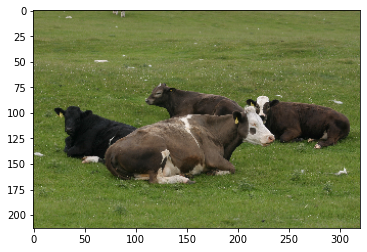

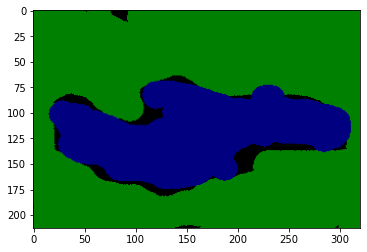

In [18]:
img = skimage.io.imread("data/MSRC_ObjCategImageDatabase_v1/" +  images_path[5])
plt.imshow(img)
plt.show()
img_seg = skimage.io.imread("data/MSRC_ObjCategImageDatabase_v1/" +  targets_path[5])
plt.imshow(img_seg)
plt.show()

In [19]:
out, out_marked, marked = get_semantic_segmentation(img, 400, 30, 1)

In [20]:
new_img = assign_labels(out, img_seg)

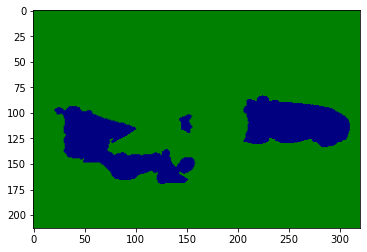

In [21]:
plt.imshow(new_img)

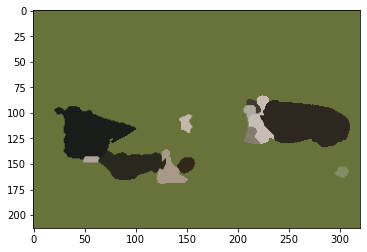

In [22]:
plt.imshow(out)

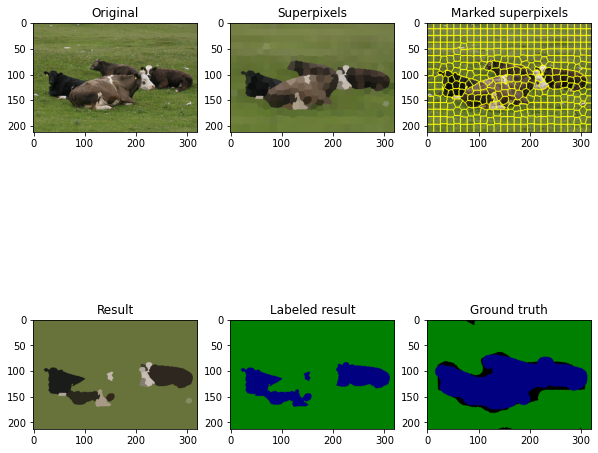

In [23]:
plot_segmented_images(img, img_seg, 400, 30, 1)

In [24]:
pixel_accuracy(new_img, img_seg)

0.8102699530516432

In [25]:
jaccard_similarity(new_img, img_seg)

0.6615140317589604

In [26]:
def evaluate_semantic_segmentation(img_path, trg_path, n_segments=400, compactness=30, sigma=1):
    img = skimage.io.imread("data/MSRC_ObjCategImageDatabase_v1/" + img_path)
    trg = skimage.io.imread("data/MSRC_ObjCategImageDatabase_v1/" + trg_path)

    img_seg, _, _ = get_semantic_segmentation(img, n_segments=400, compactness=30, sigma=1)
    img_labeled = assign_labels(img_seg, trg)
    

    pixel_acc = pixel_accuracy(img_labeled, trg)
    jaccard_sim = jaccard_similarity(img_labeled, trg)

    return pixel_acc, jaccard_sim

In [37]:
results = dict()
results["image_class"] = []
results["image_name"] = []
results["pixel_acc"] = []
results["jaccard_sim"] = []

for img_class in image_clases:
    images = datasets[img_class]["src"]
    targets = datasets[img_class]["trg"]
    
    img_class_pixel_acc = []
    img_class_jaccard_sim = []

    with tqdm(total=len(images)) as pbar:
        for img, trg in zip(images[:2], targets[:2]):

            results["image_class"].append(img_class)
            results["image_name"].append(img)

            pixel_acc, jaccard_sim = evaluate_semantic_segmentation(img, trg)
            img_class_pixel_acc.append(pixel_acc)
            img_class_jaccard_sim.append(jaccard_sim)

            results["pixel_acc"].append(pixel_acc)
            results["jaccard_sim"].append(jaccard_sim)
            
            pbar.update(1)
    

  7%|▋         | 2/30 [00:28<06:36, 14.18s/it]


In [38]:
results_df = pd.DataFrame(results)
results_df.head(10)

,image_class,image_name,pixel_acc,jaccard_sim
0,1,1_10_s.bmp,0.719865,0.530028
1,1,1_11_s.bmp,0.462588,0.219493
2,2,2_10_s.bmp,0.808553,0.679144
3,2,2_11_s.bmp,0.782702,0.630566
4,3,3_10_s.bmp,0.851540,0.751652
5,3,3_11_s.bmp,0.707864,0.523549
6,4,4_10_s.bmp,0.841843,0.728819
7,4,4_11_s.bmp,0.873005,0.775529
8,5,5_10_s.bmp,0.827567,0.754663
9,5,5_11_s.bmp,0.914070,0.840102


In [40]:
results_df[["image_class", "pixel_acc", "jaccard_sim"]].groupby("image_class", as_index=False).mean()

,image_class,pixel_acc,jaccard_sim
0,1,0.591227,0.374760
1,2,0.795628,0.654855
2,3,0.779702,0.637601
3,4,0.857424,0.752174
4,5,0.870819,0.797383
5,6,0.941337,0.892921
6,7,0.787229,0.642751
7,8,0.571457,0.376789
